### 1 - Importing necessary libraries and loading the data

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("../data/raw/prompts_v0.csv")
df.head()

,prompt,cluster,sub_class
0,How can I integrate a chatbot into my e-commer...,Communication,Chatbots and Virtual Assistants
1,What are the best practices for designing a vi...,Communication,Chatbots and Virtual Assistants
2,"Can chatbots handle complex customer queries, ...",Communication,Chatbots and Virtual Assistants
3,What technologies are commonly used to develop...,Communication,Chatbots and Virtual Assistants
4,How do I train a chatbot to understand differe...,Communication,Chatbots and Virtual Assistants


In [3]:
df["cluster"].value_counts()

Communication                  45
Music and Audio                45
Programming and Development    30
Business and Productivity      30
Name: cluster, dtype: int64

#### Encoding the labels

In [4]:
target_map = {
    "Communication": 0,
    "Music and Audio": 1,
    "Programming and Development": 2,
    "Business and Productivity": 3,
}

df["target"] = df["cluster"].map(target_map)

In [5]:
df.head()

,prompt,cluster,sub_class,target
0,How can I integrate a chatbot into my e-commer...,Communication,Chatbots and Virtual Assistants,0
1,What are the best practices for designing a vi...,Communication,Chatbots and Virtual Assistants,0
2,"Can chatbots handle complex customer queries, ...",Communication,Chatbots and Virtual Assistants,0
3,What technologies are commonly used to develop...,Communication,Chatbots and Virtual Assistants,0
4,How do I train a chatbot to understand differe...,Communication,Chatbots and Virtual Assistants,0


In [6]:
cluster_df = df[["prompt", "target"]]
cluster_df.columns = ["prompt", "label"]
cluster_df.head()

,prompt,label
0,How can I integrate a chatbot into my e-commer...,0
1,What are the best practices for designing a vi...,0
2,"Can chatbots handle complex customer queries, ...",0
3,What technologies are commonly used to develop...,0
4,How do I train a chatbot to understand differe...,0


In [9]:
cluster_df.to_csv("../data/interim/cluster_data.csv", index=False)

### 2 - Splitting the data

In [7]:
from datasets import load_dataset

raw_dataset = load_dataset("csv", data_files="../data/interim/cluster_data.csv")

d:\Softwares\anaconda\envs\llm-data-analyst\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['prompt', 'label'],
        num_rows: 150
    })
})

In [9]:
split = raw_dataset["train"].train_test_split(test_size=0.3, seed=42)

In [10]:
split

DatasetDict({
    train: Dataset({
        features: ['prompt', 'label'],
        num_rows: 105
    })
    test: Dataset({
        features: ['prompt', 'label'],
        num_rows: 45
    })
})

### 3 - Tokenization

#### Loading the tokenizer

In [11]:
from transformers import AutoTokenizer

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [12]:
tokenizer("Hello world")

{'input_ids': [101, 7592, 2088, 102], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}

#### Tokenizing the data

In [13]:
def tokenize_fn(batch):
    return tokenizer(batch["prompt"], truncation=True)

In [14]:
tokenized_dataset = split.map(tokenize_fn, batched=True)

Map: 100%|██████████| 45/45 [00:00<00:00, 368.39 examples/s]


### 4 - Fine-tuning a pretrained model

#### Loading the model from transformers

In [17]:
from transformers import AutoModelForSequenceClassification

In [18]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Model Summary

In [19]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                       Param #
BertForSequenceClassification                                --
├─BertModel: 1-1                                             --
│    └─BertEmbeddings: 2-1                                   --
│    │    └─Embedding: 3-1                                   23,440,896
│    │    └─Embedding: 3-2                                   393,216
│    │    └─Embedding: 3-3                                   1,536
│    │    └─LayerNorm: 3-4                                   1,536
│    │    └─Dropout: 3-5                                     --
│    └─BertEncoder: 2-2                                      --
│    │    └─ModuleList: 3-6                                  85,054,464
│    └─BertPooler: 2-3                                       --
│    │    └─Linear: 3-7                                      590,592
│    │    └─Tanh: 3-8                                        --
├─Dropout: 1-2                                               --
├─L

#### Compiling the model

In [15]:
from transformers import Trainer, TrainingArguments

In [16]:
training_args = TrainingArguments(
    output_dir="../models/cluster_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
)

#### Defining the ecaluation metrics

In [20]:
def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)
    acc = np.mean(predictions == labels)
    f1 = f1_score(labels, predictions, average="micro")
    return {"accuracy": acc, "f1_score": f1}

#### Training the model

In [21]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [22]:
trainer.train()

                                              
 17%|█▋        | 7/42 [00:34<02:16,  3.90s/it]

{'eval_loss': 1.2656211853027344, 'eval_accuracy': 0.5333333333333333, 'eval_f1_score': 0.5333333333333333, 'eval_runtime': 3.281, 'eval_samples_per_second': 13.715, 'eval_steps_per_second': 0.305, 'epoch': 1.0}


                                               
 33%|███▎      | 14/42 [01:04<01:38,  3.51s/it]

{'eval_loss': 0.870151698589325, 'eval_accuracy': 0.6888888888888889, 'eval_f1_score': 0.6888888888888889, 'eval_runtime': 2.4669, 'eval_samples_per_second': 18.242, 'eval_steps_per_second': 0.405, 'epoch': 2.0}


                                               
 50%|█████     | 21/42 [01:31<01:08,  3.24s/it]

{'eval_loss': 0.6127246618270874, 'eval_accuracy': 0.9111111111111111, 'eval_f1_score': 0.9111111111111111, 'eval_runtime': 2.5151, 'eval_samples_per_second': 17.892, 'eval_steps_per_second': 0.398, 'epoch': 3.0}


                                               
 67%|██████▋   | 28/42 [02:01<00:49,  3.51s/it]

{'eval_loss': 0.3927149176597595, 'eval_accuracy': 0.9777777777777777, 'eval_f1_score': 0.9777777777777777, 'eval_runtime': 2.5199, 'eval_samples_per_second': 17.858, 'eval_steps_per_second': 0.397, 'epoch': 4.0}


                                               
 83%|████████▎ | 35/42 [02:35<00:25,  3.65s/it]

{'eval_loss': 0.29268357157707214, 'eval_accuracy': 0.9555555555555556, 'eval_f1_score': 0.9555555555555556, 'eval_runtime': 2.7265, 'eval_samples_per_second': 16.505, 'eval_steps_per_second': 0.367, 'epoch': 5.0}


                                               
100%|██████████| 42/42 [03:17<00:00,  3.46s/it]

{'eval_loss': 0.2646048367023468, 'eval_accuracy': 0.9777777777777777, 'eval_f1_score': 0.9777777777777777, 'eval_runtime': 3.0747, 'eval_samples_per_second': 14.635, 'eval_steps_per_second': 0.325, 'epoch': 6.0}


100%|██████████| 42/42 [03:36<00:00,  3.46s/it]

{'train_runtime': 216.835, 'train_samples_per_second': 2.905, 'train_steps_per_second': 0.194, 'train_loss': 0.5902703148978097, 'epoch': 6.0}


100%|██████████| 42/42 [03:37<00:00,  5.18s/it]


TrainOutput(global_step=42, training_loss=0.5902703148978097, metrics={'train_runtime': 216.835, 'train_samples_per_second': 2.905, 'train_steps_per_second': 0.194, 'total_flos': 7501369222776.0, 'train_loss': 0.5902703148978097, 'epoch': 6.0})

### 5 - Evaluating the model

#### Loading the best performed model

In [23]:
from transformers import pipeline

In [24]:
saved_model = pipeline(
    "text-classification", model="../models/cluster_models/checkpoint-42"
)

In [25]:
split["test"]

Dataset({
    features: ['prompt', 'label'],
    num_rows: 45
})

#### Making predictions on the test data

In [26]:
predictions = saved_model(split["test"]["prompt"])

In [27]:
predictions[:5]

[{'label': 'LABEL_1', 'score': 0.8681304454803467},
 {'label': 'LABEL_1', 'score': 0.8436233997344971},
 {'label': 'LABEL_3', 'score': 0.7365928888320923},
 {'label': 'LABEL_0', 'score': 0.6886739134788513},
 {'label': 'LABEL_3', 'score': 0.48987478017807007}]

#### Evaluation Metrics

In [28]:
def get_label(d):
    return int(d["label"].split("_")[1])


predictions = [get_label(d) for d in predictions]

In [29]:
print("Test Accuracy:", accuracy_score(split["test"]["label"], predictions))

Test Accuracy: 0.9777777777777777


In [30]:
print("Test F1 Score:", f1_score(split["test"]["label"], predictions, average="macro"))

Test F1 Score: 0.9782214156079855


#### Confusion Matrix

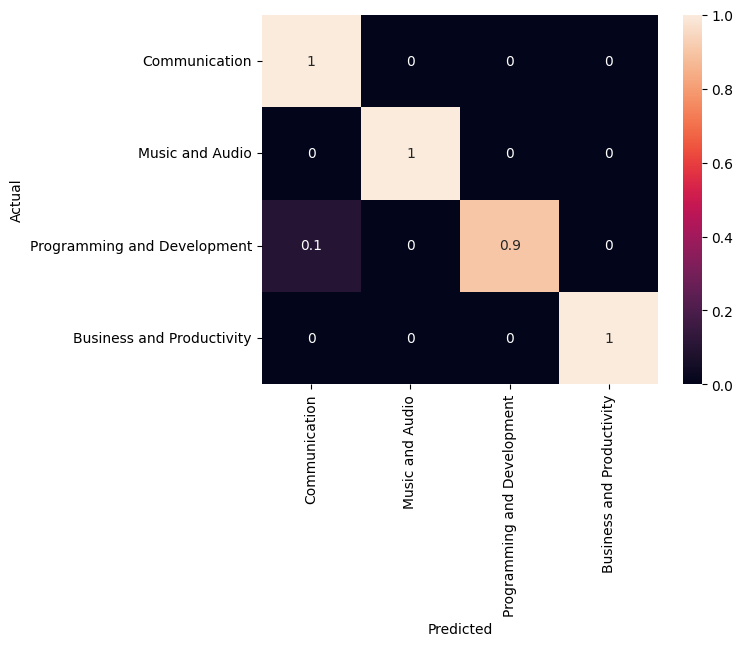

In [31]:
# create function for plotting confusion matrix
def plot_cm(cm):
    classes = [
        "Communication",
        "Music and Audio",
        "Programming and Development",
        "Business and Productivity",
    ]
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sns.heatmap(df_cm, annot=True, fmt="g")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")


cm = confusion_matrix(split["test"]["label"], predictions, normalize="true")
plot_cm(cm)

#### Custom prompts

In [61]:
def predict(text):
    prediction = saved_model(text)
    if prediction[0]["score"] < 0.5:
        return "General Model"
    label = get_label(prediction[0])
    cluster = list(target_map.keys())[label]
    return cluster

In [62]:
predict("Help me automate digital marketing tasks.")

'Business and Productivity'

In [63]:
predict("How do I structure my research paper?")

'General Model'

In [ ]:
# Understand how to predict the sub classification (stage 2 in Google AI Studio)
#    - This seems completely seperated from my previous model. I would like to make use of that model too. Let me give you my code for better understanding:
#    - I have a model that predicts the cluster of a prompt. I would like include that model to predict the sub classification of a prompt.

# Use these two approaches: https://github.com/pritishmishra703/NLP-With-Transformers-Book-Notes/blob/master/P1_TextClassification.ipynb
#   - https://www.youtube.com/watch?v=IzbjGaYQB-U&t=442s

# Final approach would be using LLMs itself